In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold,cross_val_score,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')
mpl.style.use('ggplot')
%matplotlib inline

In [2]:
data = pd.read_csv('hotel_bookings.csv')

In [3]:
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
# 将月份映射为数字
data['arrival_date_month'] = data['arrival_date_month'].map({'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12,
       'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6})

In [5]:
na_columns = []
for column in data.columns:
    na_values = data[column].isnull().sum()
    if na_values>0:
        na_columns.append(column)
        print('{} null values : {}'.format(column,data[column].isnull().sum()))

children null values : 4
country null values : 488
agent null values : 16340
company null values : 112593


孩子为空值的以0代替，country为空值的不知道国家代码，agent为空值的设置为0，可能是自己预定的，company为空值的也设置为0

In [6]:
fill_dict = {'children':0,'country':'Unkown','agent':0,'company':0}

In [7]:
data.fillna(fill_dict,inplace=True)

In [8]:
data.isnull().any(axis=0).sum() # 所有的空值都填充了

0

In [9]:
# adr为价格 average daily rate，根据adr和大人和孩子的数量，可以计算每天每人花的钱数
# 对于有可能会出现0个大人0个孩子的情况，用np.clip，将最小值设置为1，对于这种也可以删除

data['adr_person'] = data['adr']/np.clip((data['adults'] + data['children']),1,100000)
data['stay_nights'] = data['stays_in_week_nights'] + data['stays_in_weekend_nights']

lead_time:从酒店预定到到达日期之间的天数，一般客户喜欢提前几天预定酒店

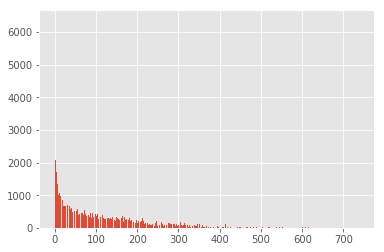

In [10]:
# 使用matplotlib绘图
lead_time = data.groupby(['lead_time'])['hotel'].agg('count')
plt.bar(lead_time.index,height=lead_time.values)
plt.show()

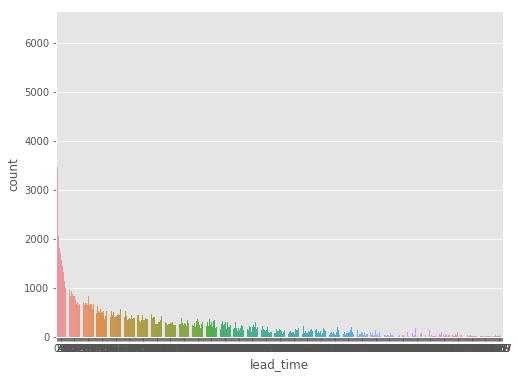

In [11]:
# 使用sns绘图
def show_column_bar(column,data):
    plt.subplots(figsize=(8,6))
    column_data = data.groupby([column])['hotel'].agg(['count']).reset_index()
    sns.barplot(x=column,y='count',data=column_data)
    plt.show()
show_column_bar('lead_time',data)

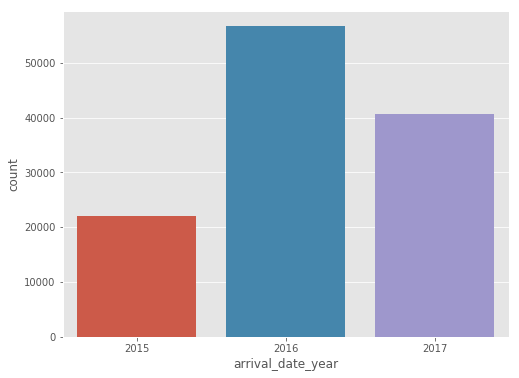

In [12]:
# 每年人数情况
show_column_bar('arrival_date_year',data)

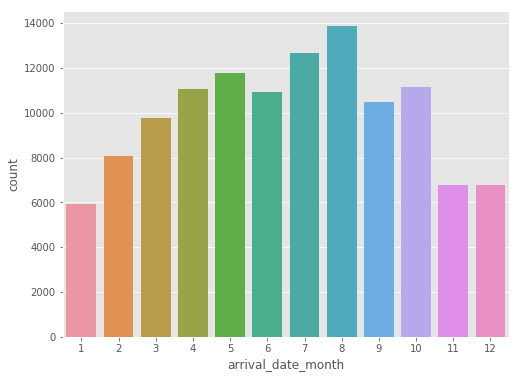

In [13]:
# 每月人数情况
show_column_bar('arrival_date_month',data)

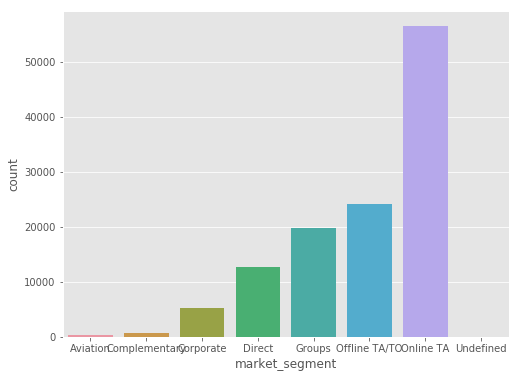

In [14]:
# 预定渠道
show_column_bar('market_segment',data)

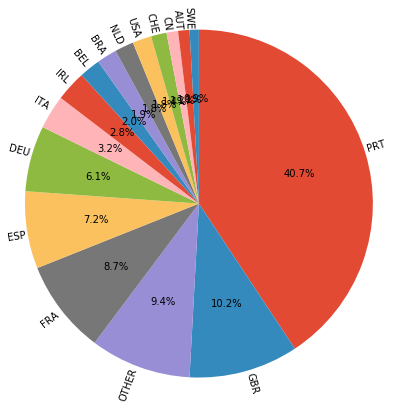

In [15]:
# 使用matplotlib绘制饼图
country = data.groupby(['country'])['hotel'].agg('count')
countries = {'OTHER':0}
for index,value in zip(country.index,country.values):
    if value < 1000:
        countries['OTHER'] += value
    else:
        countries[index] = value
countries=sorted(countries.items(),key=lambda x:x[1],reverse=True)
plt.pie([x[1] for x in countries],labels=[x[0] for x in countries],radius=2,autopct='%1.1f%%',startangle=90,counterclock=False,rotatelabels=True,labeldistance=1)
plt.show()

未取消订单的房间

In [16]:
data_keep = data[data['is_canceled']==0]

In [17]:
data_keep.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,adr_person,stay_nights
0,Resort Hotel,0,342,2015,7,27,1,0,0,2,...,0.0,0,Transient,0.0,0,0,Check-Out,2015-07-01,0.0,0
1,Resort Hotel,0,737,2015,7,27,1,0,0,2,...,0.0,0,Transient,0.0,0,0,Check-Out,2015-07-01,0.0,0
2,Resort Hotel,0,7,2015,7,27,1,0,1,1,...,0.0,0,Transient,75.0,0,0,Check-Out,2015-07-02,75.0,1
3,Resort Hotel,0,13,2015,7,27,1,0,1,1,...,0.0,0,Transient,75.0,0,0,Check-Out,2015-07-02,75.0,1
4,Resort Hotel,0,14,2015,7,27,1,0,2,2,...,0.0,0,Transient,98.0,0,1,Check-Out,2015-07-03,49.0,2


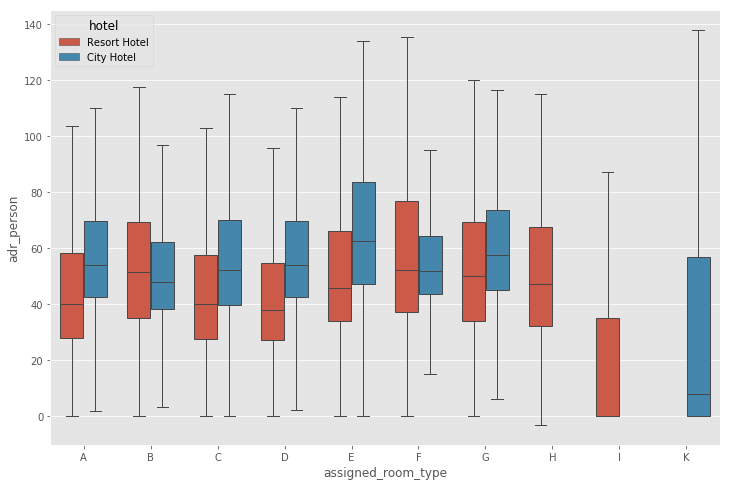

In [18]:
# 根据房型平均每个人花费金额的箱型图
plt.subplots(figsize=(12,8))
sns.boxplot(x='assigned_room_type',y='adr_person',hue='hotel',order=sorted(data_keep['assigned_room_type'].unique()),data=data_keep,showfliers=False,width=0.7,linewidth=1)
plt.show()

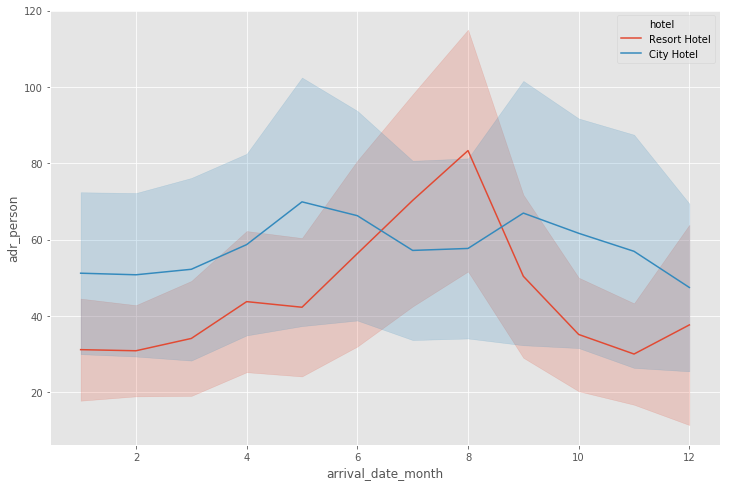

In [19]:
plt.subplots(figsize=(12,8))
sns.lineplot(x='arrival_date_month',y='adr_person',data=data_keep,hue='hotel',ci='sd')
plt.show()

In [20]:
count_month=data_keep.groupby(['hotel','arrival_date_month'])['hotel'].agg(['count']).reset_index()

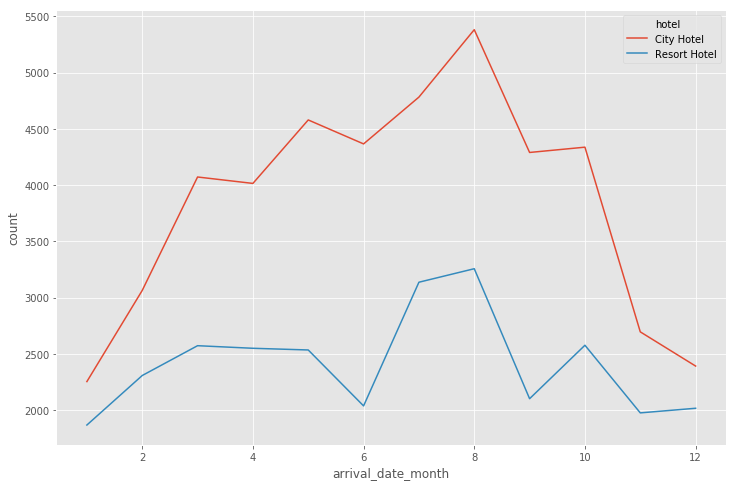

In [21]:
plt.subplots(figsize=(12,8))
sns.lineplot(x='arrival_date_month',y='count',hue='hotel',data=count_month)
plt.show()

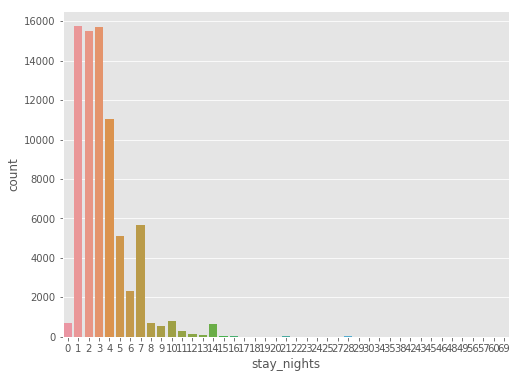

In [22]:
show_column_bar('stay_nights',data_keep)

In [23]:
# 与是否取消的相关性大小排序
data.corr()['is_canceled'].abs().sort_values(ascending=False)[1:]

lead_time                         0.293123
total_of_special_requests         0.234658
required_car_parking_spaces       0.195498
booking_changes                   0.144381
previous_cancellations            0.110133
is_repeated_guest                 0.084793
company                           0.082995
adults                            0.060017
previous_bookings_not_canceled    0.057358
days_in_waiting_list              0.054186
adr                               0.047557
agent                             0.046529
babies                            0.032491
stays_in_week_nights              0.024765
adr_person                        0.018704
stay_nights                       0.017779
arrival_date_year                 0.016660
arrival_date_month                0.011022
arrival_date_week_number          0.008148
arrival_date_day_of_month         0.006130
children                          0.005036
stays_in_weekend_nights           0.001791
Name: is_canceled, dtype: float64

In [24]:
data.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'adr_person',
       'stay_nights'],
      dtype='object')

 根据特征预测预定是否会被取消，需要对数据进行部分预处理工作，比如类似'hotel'列需要做OneHotencoder，像reservation_status这种列需要删除，因为status为 Canceled 和 No-Show的全部都是取消的,而status为 check-out的都是没有取消的
+ 删除的列: 'arrival_date_year','reservation_status','reservation_status_date'，‘company’(缺失值较多)
+ 编码的列: 'hotel', 'meal','market_segment','distribution_channel','reserved_room_type','assigned_room_type','deposit_type', 'customer_type','country'

In [25]:
valid_data = data.drop(columns=['arrival_date_year','reservation_status','reservation_status_date','company'])
valid_data['changed'] = valid_data['reserved_room_type']==data['assigned_room_type']

In [26]:
valid_data=pd.get_dummies(valid_data,columns=['hotel', 'meal','market_segment','distribution_channel','reserved_room_type','assigned_room_type','deposit_type', 'customer_type','country'])

In [27]:
x = valid_data.drop('is_canceled',axis=1)
y = valid_data['is_canceled']

In [28]:
models = {
    'rf_model':RandomForestClassifier(),
    'dt_model':DecisionTreeClassifier(),
    'lr_model':LogisticRegression(),
    'xgb_model':XGBClassifier()
}

In [29]:
score_list = {}
cv = KFold(n_splits=10,shuffle=True)
for name,model in models.items():
    pipe_estimator = Pipeline([(name,model)])
    print('starting:{}'.format(name))
    cv_results = cross_val_score(pipe_estimator,x,y,cv=cv,)
    score_list[name] = cv_results

starting:rf_model
starting:dt_model
starting:lr_model
starting:xgb_model


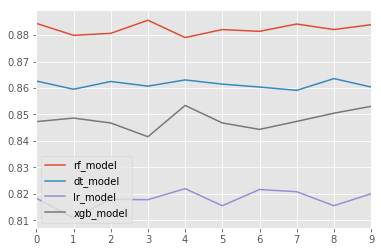

In [30]:
pd.DataFrame(score_list).plot()

In [31]:
param_grid = {'n_estimators':[1000,2000,5000]}

In [32]:
model = RandomForestClassifier(n_jobs=-1)
gs = GridSearchCV(model,param_grid=param_grid,cv=KFold(n_splits=3,shuffle=True),verbose=True)

In [33]:
gs.fit(x,y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 32.8min finished


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [1000, 2000, 5000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [34]:
gs.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [35]:
gs.best_score_

0.8917497277828964